In [1]:
import sys
print(sys.executable)

c:\Users\Ray Joshi\Desktop\MLFlow\venv\python.exe


In [2]:
!python --version

Python 3.9.16


### Functions for all the steps involved in complete model training lifecycle

In [3]:
import pandas as pd
import numpy as np

In [4]:
def load_data(path):
    data = pd.read_csv(path)
    return data


In [5]:
data = load_data('https://raw.githubusercontent.com/TripathiAshutosh/dataset/main/banking.csv')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [6]:
def data_cleaning(data):
    print("na values available in data \n")
    print(data.isna().sum())
    data = data.dropna()
    print("after dropping na values \n")
    print(data.isna().sum())
    return data

In [7]:
def preprocessing(data):
    data['education'] = np.where(data['education'] == 'basic.9y', 'Basic', data['education'])
    data['education'] = np.where(data['education'] == 'basic.6y', 'Basic', data['education'])
    data['education'] = np.where(data['education'] == 'basic.4y', 'Basic', data['education'])

    cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
    for var in cat_vars:
        cat_list = 'var' + '_' + var
        cat_list = pd.get_dummies(data[var], prefix = var)
        data1 = data.join(cat_list)
        data = data1
    
    cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
    data_vars = data.columns.values.tolist()
    to_keep = [i for i in data_vars if i not in cat_vars]

    final_data = data[to_keep]

    final_data.columns = final_data.columns.str.replace('.', '_')
    final_data.columns = final_data.columns.str.replace(' ', '_')
    return final_data

In [8]:
def train_test_split(final_data):
    from sklearn.model_selection import train_test_split
    X = final_data.loc[:, final_data.columns != 'y']
    y = final_data.loc[:, final_data.columns == 'y']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42)
    return X_train, X_test, y_train, y_test

In [9]:
def over_sampling_target_class(X_train, y_train):
    # Oversampling using SMOTE
    from imblearn.over_sampling import SMOTE
    os = SMOTE(random_state = 0)

    columns = X_train.columns
    os_data_X, os_data_y = os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data = os_data_X, columns = columns)
    os_data_y = pd.DataFrame(data = os_data_y, columns = ['y'])

    # We can check the numbers of our data
    print("Length of oversampled data is: ", len(os_data_X))
    print("Number of no subscription in oversampled data is: ", len(os_data_y[os_data_y['y'] == 0]))
    print("Number of subscription: ", len(os_data_y[os_data_y['y'] == 1]))
    print("Proportion of no subscription in oversampled data is: ", len(os_data_y[os_data_y['y'] == 0])/len(os_data_X))
    print("Proportion of subscription is: ", len(os_data_y[os_data_y['y'] == 1])/len(os_data_X))

    X_train = os_data_X
    y_train = os_data_y

    return X_train, y_train

In [10]:
def training_basic_classifier(X_train, y_train):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=101)
    model.fit(X_train, y_train)

    return model

In [11]:
def predict_on_test_data(model, X_test):
    y_pred = model.predict(X_test)
    return y_pred

In [26]:
def predict_prob_on_test_data(model, X_test):
    y_pred = model.predict_proba(X_test)
    return y_pred

In [40]:
def get_metrics(y_true, y_pred, y_pred_prob):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    entropy = log_loss(y_true, y_pred_prob)
    return {'accuracy' : round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2), 'entropy': round(entropy, 2)}

In [14]:
def create_roc_auc_plot(clf, X_data, y_data):
    import matplotlib.pyplot as plt
    from sklearn import metrics
    metrics.plot_roc_curve(clf, X_data, y_data)
    plt.savefig('roc_auc_curve.png')

In [16]:
def create_confusion_matrix_plot(clf, X_test, y_test):
    import matplotlib.pyplot as plt
    from sklearn.metrics import plot_confusion_matrix
    plot_confusion_matrix(clf, X_test, y_test)
    plt.savefig('confusion_matrix.png')

In [18]:
def hyper_parameter_tuning(X_train, y_train):
    # Define random hyperparameters
    n_estimators = [5, 21, 50, 100] # Number of trees in RF
    max_features = ['auto', 'sqrt'] # Number of features in consideration at every split
    max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # Maximum number of levels allowed in each decision tree
    min_samples_split = [2, 6, 10] # Minimum sample number to split a node
    min_samples_leaf = [1, 3, 4] # Minimum sample number that can be stored in a leaf node
    bootstrap = [True, False] # Method used to sample data points

    random_grid = {
        'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap
    }

    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.ensemble import RandomForestClassifier
    classifier = RandomForestClassifier()
    model_tuning = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid,
                                      n_iter = 100, cv = 5, verbose = 2, random_state = 35, n_jobs = -1)
    model_tuning.fit(X_train, y_train)

    print('Random grid: ', random_grid, '\n')
    # Best parameters
    print('Best Parameters: ', model_tuning.best_params_, '\n')

    best_params = model_tuning.best_params_

    n_estimators = best_params['n_estimators']
    min_samples_split = best_params['min_samples_split']
    min_samples_leaf = best_params['min_samples_leaf']
    max_features = best_params['max_features']
    max_depth = best_params['max_depth']
    bootstrap = best_params['bootstrap']

    model_tuned = RandomForestClassifier(n_estimators = n_estimators, min_samples_split = min_samples_split,
                                         min_samples_leaf = min_samples_leaf, max_features = max_features,
                                         max_depth = max_depth, bootstrap = bootstrap)
    
    model_tuned.fit(X_train, y_train)

    return model_tuned, best_params

In [19]:
data = load_data('https://raw.githubusercontent.com/TripathiAshutosh/dataset/main/banking.csv')

In [20]:
cleaned_data = data_cleaning(data)

na values available in data 

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
after dropping na values 

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64


In [21]:
final_data = preprocessing(cleaned_data)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(final_data)

In [23]:
X_train, y_train = over_sampling_target_class(X_train, y_train)

Length of oversampled data is:  51166
Number of no subscription in oversampled data is:  25583
Number of subscription:  25583
Proportion of no subscription in oversampled data is:  0.5
Proportion of subscription is:  0.5


In [24]:
model = training_basic_classifier(X_train, y_train)

C:\Users\Ray Joshi\AppData\Local\Temp\ipykernel_32852\2910390031.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


In [25]:
y_pred = predict_on_test_data(model, X_test)

In [28]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [27]:
y_pred_prob = predict_prob_on_test_data(model, X_test)

In [29]:
y_pred_prob

array([[1.        , 0.        ],
       [0.97029703, 0.02970297],
       [1.        , 0.        ],
       ...,
       [0.99009901, 0.00990099],
       [1.        , 0.        ],
       [0.97029703, 0.02970297]])

In [30]:
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)

In [31]:
run_metrics

{'accuracy:': 0.91, 'precision: ': 0.64, 'recall: ': 0.54, 'entropy: ': 0.19}

C:\Users\Ray Joshi\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


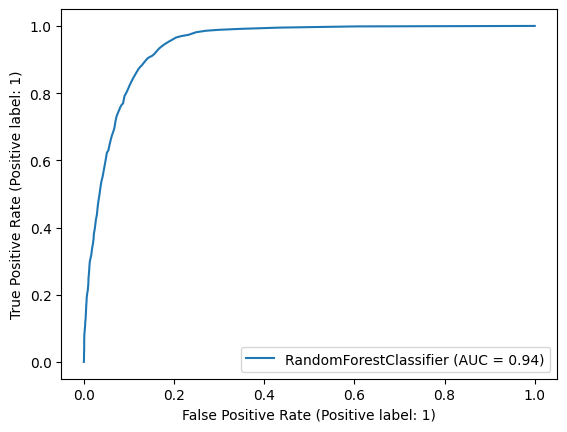

In [32]:
create_roc_auc_plot(model, X_test, y_test)

C:\Users\Ray Joshi\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


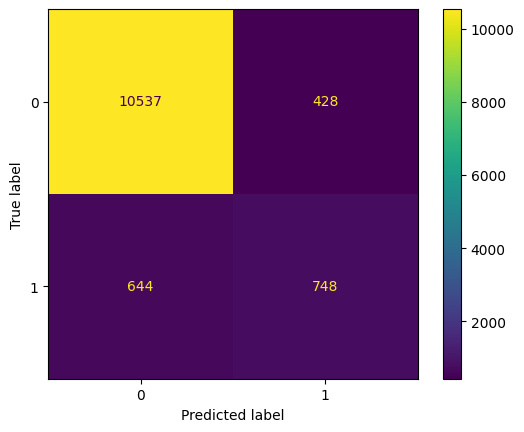

In [33]:
create_confusion_matrix_plot(model, X_test, y_test)

MLFlow Starts Here

In [41]:
experiment_name = "basic_classifier" # Basic classifier
run_name = "term_deposit"
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)
print(run_metrics)

{'accuracy': 0.91, 'precision': 0.64, 'recall': 0.54, 'entropy': 0.19}


In [44]:
create_experiment(experiment_name, run_name, run_metrics, model, 'confusion_matrix.png', 'roc_auc_curve.png')

Run - term_deposit is logged to Experiment - basic_classifier


c:\Users\Ray Joshi\Desktop\MLFlow\venv\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\Ray Joshi\Desktop\MLFlow\venv\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### Function to create an experiment in MLFlow and log parameters, metrics and artifacts files like images etc.

In [43]:
def create_experiment(experiment_name, run_name, run_metrics, model, confusion_matrix_path = None,
                      roc_auc_plot_path = None, run_params = None):
    import mlflow

    mlflow.set_experiment(experiment_name)

    with mlflow.start_run():

        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])

        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])

        mlflow.sklearn.log_model(model,'model')

        if not confusion_matrix_path == None:
            mlflow.log_artifact(confusion_matrix_path, 'confusion_matrix')

        if not roc_auc_plot_path == None:
            mlflow.log_artifact(roc_auc_plot_path, 'roc_auc_plot')

        mlflow.set_tag('tag1', 'Random Forest')
        mlflow.set_tags({'tag2': 'Randomized Search CV', 'tag3': 'Production'})

    print('Run - %s is logged to Experiment - %s' %(run_name, experiment_name))